### The CIFAR-100 Dataset


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Read the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the full training dataset
cifar100_full = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

# Create 80/20 train-validation split with fixed random seed
train_size = int(0.8 * len(cifar100_full))
val_size = len(cifar100_full) - train_size
cifar100_train, cifar100_val = random_split(cifar100_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Load test dataset
cifar100_test = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

# Create DataLoaders with batch size 128
train_loader = DataLoader(cifar100_train, batch_size=128, shuffle=True)
val_loader = DataLoader(cifar100_val, batch_size=128)
test_loader = DataLoader(cifar100_test, batch_size=128)

# Print dataset sizes and class count
print(f"Training set size: {len(cifar100_train)}")
print(f"Validation set size: {len(cifar100_val)}")
print(f"Test set size: {len(cifar100_test)}")
print(f"Number of classes: {len(cifar100_full.classes)}")


Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000
Number of classes: 100


### Visualizing Training Images


Image shape: torch.Size([3, 32, 32])
Image shape matches (3, 32, 32): True
Target type: <class 'int'>
Target is integer: True
Target value example: 42


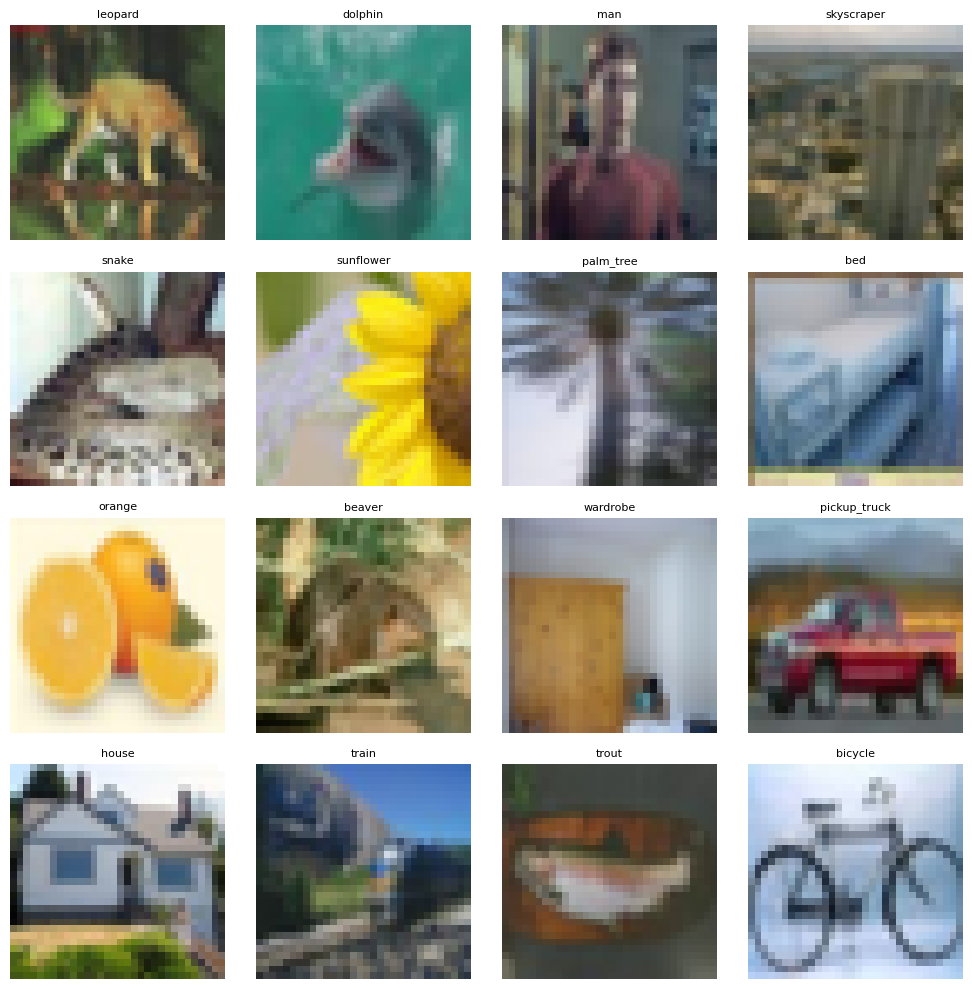

In [9]:
import matplotlib.pyplot as plt

# Get one batch from the training loader
images, labels = next(iter(train_loader))

# Confirm image shape and target type
print(f"Image shape: {images[0].shape}")
print(f"Image shape matches (3, 32, 32): {images[0].shape == (3, 32, 32)}")
print(f"Target type: {type(labels[0].item())}")
print(f"Target is integer: {isinstance(labels[0].item(), int)}")
print(f"Target value example: {labels[0].item()}")

# Plot 4×4 grid of images with class labels
plt.figure(figsize=(10, 10))
for index in range(16):
    plt.subplot(4, 4, index + 1)
    # Transpose from (C, H, W) to (H, W, C) for matplotlib
    img = images[index].numpy().transpose(1, 2, 0)
    # Get the class name for the label
    class_name = cifar100_full.classes[labels[index].item()]
    plt.imshow(img)
    plt.title(class_name, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


### Building the CNN Architecture


In [11]:
import torch.nn as nn

class Cifar100Cnn(nn.Module):
    def __init__(self):
        super(Cifar100Cnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv block 1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Conv block 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),  # assuming input is 32x32 (CIFAR)
            nn.ReLU(),
            nn.Linear(128, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn_model = Cifar100Cnn()
print(cnn_model)

# Print model summary and parameter count
total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Cifar100Cnn(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=100, bias=True)
  )
)

Total parameters: 556,708
Trainable parameters: 556,708
